# Effect of $n$ Background Datasets on Model Parameters and Output

This section explores the effect that varying the number of background datasets has on different aspects of model output. We can reuse the same `Genes` class from the previous section.

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

sns.set_style("whitegrid")

class Genes:
    def __init__(
            self, sample_dir, background_path, sample_path, sample_name, genes_path
    ):
        self.sample_dir = sample_dir
        self.background_path = background_path
        self.sample_path = sample_path
        self.sample_name = sample_name
        self.bg = None
        self.sg = None
        self.df = None
        self.classes = None
        self.w = self._weight_df()
        self.p = self._pval_df()
        self.traces = {}
        self.dfs = {}
        self.genes = [
            x.strip() for x in open(genes_path, "r").readlines() if not x.isspace()
        ]

    def _weight_df(self) -> pd.DataFrame:
        weights = []
        for subdir in os.listdir(self.sample_dir):
            max_genes = int(subdir)
            sample_name = os.listdir(os.path.join(self.sample_dir, subdir))[0]
            weight_path = os.path.join(
                self.sample_dir, subdir, sample_name, "weights.tsv"
            )
            w = pd.read_csv(weight_path, sep="\t")
            w.columns = ["tissue", "Median", "std"]
            w["sample"] = sample_name
            w["max_genes"] = int(max_genes)
            w["num_training_genes"] = int(max_genes) - 85
            weights.append(w.drop("std", axis=1))
        weights = pd.concat(weights).reset_index(drop=True)
        self.classes = sorted(weights.tissue)
        return weights.sort_values("max_genes")

    def _pval_df(self) -> pd.DataFrame:
        pvals = []
        for subdir in os.listdir(self.sample_dir):
            max_genes = int(subdir)
            sample_name = os.listdir(os.path.join(self.sample_dir, subdir))[0]
            pval_path = os.path.join(self.sample_dir, subdir, sample_name, "pvals.tsv")
            p = pd.read_csv(pval_path, sep="\t")
            p["sample"] = sample_name
            p["max_genes"] = int(max_genes)
            p["num_training_genes"] = int(max_genes) - 85
            pvals.append(p)
        pvals = pd.concat(pvals).reset_index(drop=True)
        return pvals.sort_values("max_genes")

    def _load_df(self, path):
        if path in self.dfs:
            return self.dfs[path]
        print(f"Reading in {path}")
        if path.endswith(".csv"):
            df = pd.read_csv(path, index_col=0)
        elif path.endswith(".tsv"):
            df = pd.read_csv(path, sep="\t", index_col=0)
        else:
            try:
                df = pd.read_hdf(path)
            except Exception as e:
                print(e)
                raise RuntimeError(f"Failed to open DataFrame: {path}")
        self.dfs[path] = df
        return df

    @staticmethod
    def _load_model(pkl_path):
        with open(pkl_path, "rb") as buff:
            data = pickle.load(buff)
        return data["model"], data["trace"]

    def _df(self, gene, tissue) -> pd.DataFrame:
        p = []
        for i, subdir in enumerate(os.listdir(self.sample_dir)):
            max_genes = int(subdir)
            sample_name = os.listdir(os.path.join(self.sample_dir, subdir))[0]
            if subdir in self.traces:
                t = self.traces[subdir]
            else:
                if i == 0:
                    print("Loading traces to extract posterior distribution")
                model_path = os.path.join(
                    self.sample_dir, subdir, sample_name, "model.pkl"
                )
                m, t = self._load_model(model_path)
                self.traces[subdir] = t
            # Calculate PPC
            ppc = self._posterior_predictive_check(t, [gene])
            df = pd.DataFrame()
            df["ppc"] = ppc[gene]
            df["x"] = t[f"{gene}={tissue}"]
            df["max_genes"] = max_genes
            df["num_training_genes"] = int(max_genes) - 85
            p.append(df)
        p = pd.concat(p).reset_index(drop=True)
        return p.sort_values("max_genes")

    def t_fits(self, backgrounds, group='tissue'):
        """
        StudentT distribution fits for every dataset/gene pair

        Args:
            df: Background dataframe to use in comparison
            genes: Genes to fit
            backgrounds: Background datasets to fit
            group: Column in background dataset to use as labels

        Returns:
            StudentT fits for every gene-dataset pair
        """
        df = self._load_df(self.background_path)
        genes = self.genes
        fits = {}
        for gene in genes:
            for i, dataset in enumerate(backgrounds):
                # "intuitive" prior parameters
                prior_mean = 0.0
                prior_std_dev = 1.0
                pseudocounts = 1.0

                # convert to prior params of normal-inverse gamma
                kappa_0 = pseudocounts
                mu_0 = prior_mean
                alpha_0 = 0.5 * pseudocounts
                beta_0 = 0.5 / prior_std_dev ** 2

                # collect summary statistics for data
                observations = np.array(df[df[group] == dataset][gene])
                n = len(observations)
                obs_sum = np.sum(observations)
                obs_mean = obs_sum / n
                obs_ssd = np.sum(np.square(observations - obs_mean))

                # compute the posterior params
                kappa_n = kappa_0 + n
                mu_n = (kappa_0 * mu_0 + obs_sum) / (kappa_0 + n)
                alpha_n = alpha_0 + 0.5 * n
                beta_n = beta_0 + 0.5 * (
                        obs_ssd + kappa_0 * n * (obs_mean - mu_0) ** 2 / (kappa_0 + n)
                )

                # from https://www.seas.harvard.edu/courses/cs281/papers/murphy-2007.pdf, 
                # Equation (110)
                # convert to the params of a PyMC student-t (i.e. integrate out the prior)
                mu = mu_n
                nu = 2.0 * alpha_n
                lam = alpha_n * kappa_n / (beta_n * (kappa_n + 1.0))

                fits[f"{gene}={dataset}"] = (mu, nu, lam, np.sqrt(1 / lam))
        return fits

    def _posterior_predictive_check(self, trace, genes):
        """
        Posterior predictive check for a list of genes trained in the model

        Args:
            trace: PyMC3 trace
            fits: StudentT fits for background dataset/gene expression
            genes: List of genes of interest

        Returns:
            Dictionary of [genes, array of posterior sampling]
        """
        fits = self.t_fits(self.classes)
        d = {}
        for gene in genes:
            d[gene] = self._gene_ppc(trace, fits, gene)
        return d

    @staticmethod
    def _gene_ppc(trace, fits, gene: str) -> np.array:
        """
        Calculate posterior predictive for a gene

        Args:
            trace: PyMC3 Trace
            fits: StudentT fits for background dataset/gene expression
            gene: Gene of interest

        Returns:
            Random variates representing PPC of the gene
        """
        y_gene = [x for x in trace.varnames if x.startswith(f"{gene}=")]
        y, norm_term = 0, 0
        multiple_backgrounds = "b" in trace.varnames
        for i, y_name in enumerate(y_gene):
            nu, mu, lam, sd = fits[y_name]
            b = trace["b"][:, i] if multiple_backgrounds else 1
            y += (b / sd) * trace[y_name]
            norm_term += b / sd

        return np.random.laplace(loc=(y / norm_term), scale=(trace["eps"] / norm_term))

    def _pearson_pvalue_matrix(self):
        df = self.p
        matrix = []
        df = df[df.Gene.isin(self.genes)]
        ntg_vector = df.num_training_genes.unique()
        for i in ntg_vector:
            row = []
            d1 = df[df.num_training_genes == i]
            d1.index = d1.Gene
            for j in ntg_vector:
                d2 = df[df.num_training_genes == j]
                d2.index = d2.Gene
                # Combine and index by gene
                c = pd.concat([d1.Pval, d2.Pval], axis=1)
                c.columns = [0, 1]
                r, _ = pearsonr(c[0], c[1])
                row.append(r)
            matrix.append(row)
        matrix = pd.DataFrame(matrix, index=ntg_vector, columns=ntg_vector)
        return matrix.apply(lambda x: round(x, 4))

    def plot_genes_by_weights(self):
        _, ax = plt.subplots(figsize=(8, 4))
        sns.lineplot(data=self.w, x="num_training_genes", y="Median", hue="tissue")
        plt.xlabel("Number of Additional Training Genes")
        plt.ylabel("Median Beta Coefficient")
        plt.ylim([0, 1])
        plt.title("Effect of Adding Training Genes on Beta Weights")
        return ax

    def plot_x(self, gene, tissue):
        self.bg = self._load_df(self.background_path) if self.bg is None else self.bg
        self.sg = self._load_df(self.sample_path) if self.sg is None else self.sg
        self.df = self._df(gene, tissue)

        _, ax = plt.subplots(figsize=(8, 5))
        plt.axvline(self.sg.loc[self.sample_name][gene], label="N-of-1", c="r")
        gr = df.groupby("num_training_genes")["x"]
        for label, arr in gr:
            sns.kdeplot(arr, label=label)
        sns.kdeplot(self.bg[self.bg.tissue == tissue][gene], shade=True, label="Observed")
        plt.xlabel("Transcripts per Million (log2(TPM +1))")
        plt.ylabel("Density")
        plt.title(f"Effect of n Genes on x Distribution - {gene}")
        return ax

    def plot_posterior(self, gene, tissue):
        self.bg = self._load_df(self.background_path) if self.bg is None else self.bg
        self.sg = self._load_df(self.sample_path) if self.sg is None else self.sg
        df = self._df(gene, tissue)

        _, ax = plt.subplots(figsize=(8, 5))
        plt.axvline(self.sg.loc[self.sample_name][gene], label="N-of-1", c="r")
        gr = df.groupby("num_training_genes")["ppc"]
        for label, arr in gr:
            sns.kdeplot(arr, label=label)
        sns.kdeplot(self.bg[self.bg.tissue == tissue][gene], shade=True, label="Observed")
        plt.xlabel("Transcripts per Million (log2(TPM +1))")
        plt.ylabel("Density")
        plt.title(f"Effect of n Genes on Posterior Distribution - {gene}")
        return ax

    def plot_pval_heatmap(self):
        matrix = self._pearson_pvalue_matrix()
        f, ax = plt.subplots(figsize=(12, 4))
        sns.heatmap(matrix, cmap="Blues", annot=True, linewidths=0.5)
        plt.xlabel("Number of Additional Training Genes")
        plt.ylabel("Number of Additional Training Genes")
        plt.title(
            "Pearson Correlation of Gene P-values (n=85) as Training Genes are Added"
        )
        return ax

## Select Sample

In [2]:
# We'll select the same sample as variable-genes here
sample_id = 'TCGA-DJ-A2PX-01'

## Manifest

In [3]:
out_dir = '/mnt/normsd-outlier-runs/variable-backgrounds/output'
path = os.path.join(os.path.dirname(out_dir), 'manifest.tsv')
num_bgs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
with open(path, 'w') as f:
    f.write('id\tnum_backgrounds\tout_dir\n')
    for x in num_bgs:
        sample_dir = os.path.join(out_dir, str(x))
        f.write(f'{sample_id}\t{x}\t{sample_dir}\n')

## Run Samples

```
#!/usr/bin/env bash
source activate toil
python /mnt/gene-outlier-detection/toil/toil-outlier-detection.py \
    --sample /mnt/data/outlier/tumor.hd5 \
    --background /mnt/data/outlier/gtex.hd5 \
    --gene-list /mnt/data/outlier/drug-genes.txt \
    --manifest /mnt/normsd-outlier-runs/variable-backgrounds/manifest.tsv \
    --out-dir /mnt/normsd-outlier-runs/variable-backgrounds/output/ \
    --group tissue \
    --col-skip 5 \
    --num-backgrounds 1 \
    --max-genes 105 \
    --workDir /mnt/ \
    --disable-iter \
    /mnt/jobStore
```

## Background Sets by Weights

In [4]:
out_dir = '/mnt/normsd-outlier-runs/variable-backgrounds/output'
g = Genes(
    out_dir,
    '/mnt/data/outlier/gtex.hd5',
    '/mnt/data/outlier/tumor.hd5',
    'TCGA-DJ-A2PX-01',
    '/mnt/data/outlier/drug-genes.txt',
)

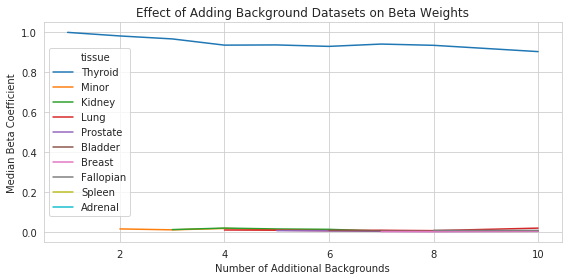

In [5]:
out_dir = '/mnt/figures/variable-backgrounds'
df = g.w
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='max_genes', y='Median', hue='tissue')
plt.xlabel('Number of Additional Backgrounds')
plt.ylabel('Median Beta Coefficient')
plt.title('Effect of Adding Background Datasets on Beta Weights');
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'weights.png'), dpi=300, transparent=True)

## Effect of $n$ Background Datasets on $x$ Distribution

### Random Genes

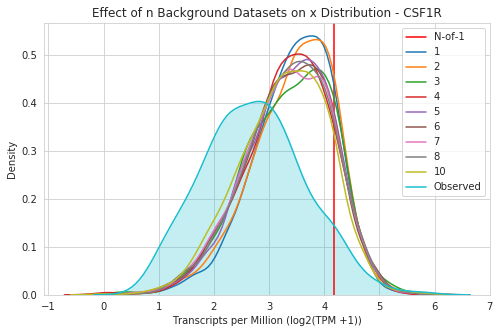

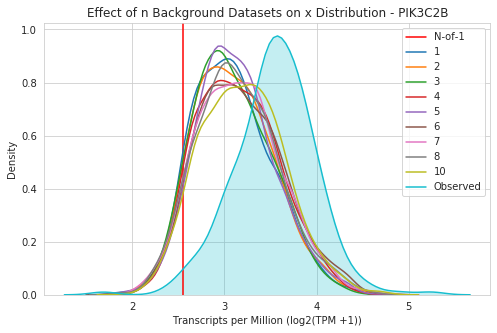

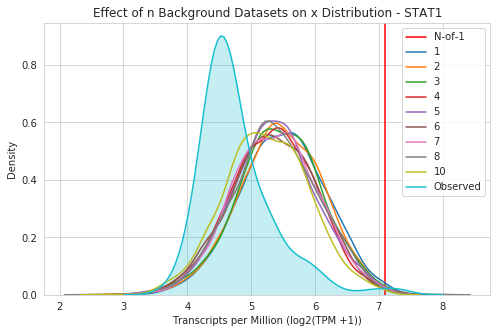

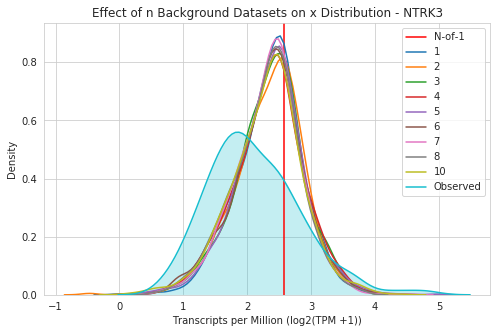

In [15]:
ran_genes = np.random.choice(g.genes, 4)
for gene in ran_genes:
    ax = g.plot_x(gene, 'Thyroid');
    ax.set_title(f'Effect of n Background Datasets on x Distribution - {gene}')
    L = plt.legend()
    for i, n in enumerate(n_bgs):
        L.get_texts()[i+1].set_text(n)

## Effect of $n$ Background Datasets on Posterior Predictive Distribution

### Random Genes

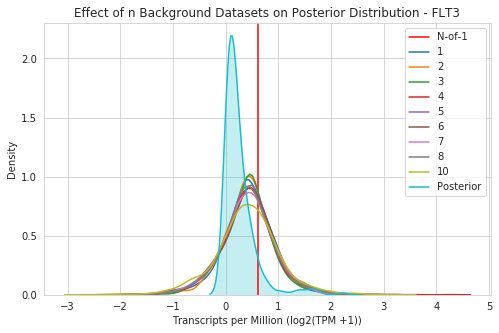

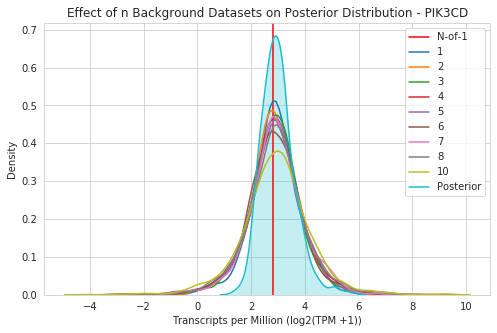

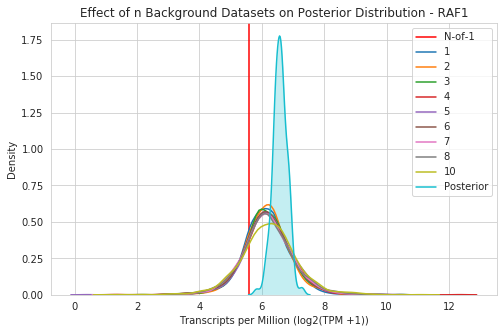

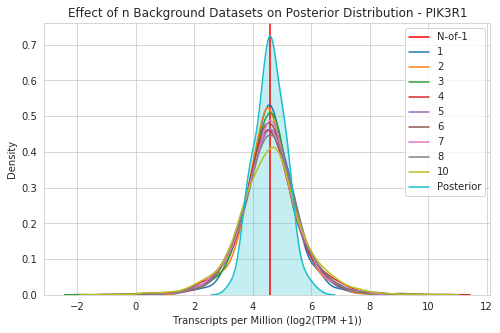

In [16]:
ran_genes = np.random.choice(g.genes, 4)
for gene in ran_genes:
    ax = g.plot_posterior(gene, 'Thyroid');
    ax.set_title(f'Effect of n Background Datasets on Posterior Distribution - {gene}')
    L = plt.legend()
    for i, n in enumerate(n_bgs):
        L.get_texts()[i+1].set_text(n)
        L.get_texts()[-1].set_text('Posterior')

## P-value Posterior Heatmap

Similar to the previous section, we want to know the effect of additional background training sets on the p-values the model generates. This can be visualized by calculating the Pearson correlation between all variable runs.

For this sample, the first background dataset was the matched normal from GTEx, which is why the pearson correlation between gene p-values remains static regardless of the number of additional background datasets that are added.

In [17]:
matrix = g._pearson_pvalue_matrix()
matrix.index = range(1, 10)
matrix.columns = range(1, 10)

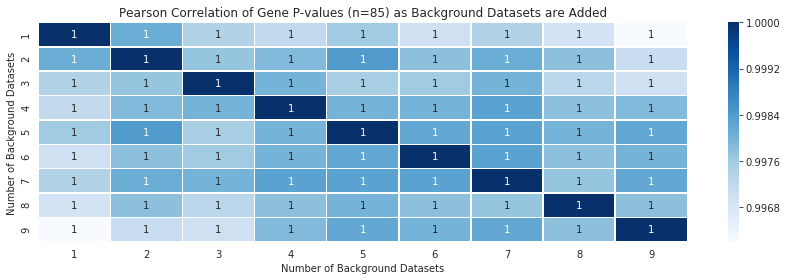

In [18]:
plt.figure(figsize=(12, 4))
sns.heatmap(matrix, cmap='Blues', annot=True, linewidths=0.5)
plt.xlabel('Number of Background Datasets')
plt.ylabel('Number of Background Datasets')
plt.title('Pearson Correlation of Gene P-values (n=85) as Background Datasets are Added');
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'heatmap.png'), dpi=300, transparent=True)